# Data Challenge

### Problem Statement:

The CSV we have provided contains data extracted from videos of patients captured using the
Machine Medicine Technologies product KELVIN. The columns relate to body measurements, for
instance the “height” column is the height of the patient, the “face” column is the length of the face,
etc. The “var1”,…,”var4” columns are additional variables, it is not important to know what these
are.

### Tasks:

- List three things that one should consider in terms of pre-processing this specific data set.
- Guess what the unit of measurement of patient height in this dataset.
- Write a function that creates a plot of the distribution for a column of the data.
- Visually summarise the entire dataset in whichever way you think is most appropriate.
- Using this dataset, provide an estimate of the average patient height. Is it significantly greater
than 750?
- Characterise the distribution of the torso length (i.e. a sentence with numeric values).
- Using whichever statistical test you think appropriate, examine the difference between the
length of left arm and length of right arm.
- Compare the “left_shin” and “left_shin2” columns – what conclusion can you draw?
- Train a simple model to predict height using all other variables. Visualise the performance of this
model.
- Train a more complex model to predict height. Compare the performance of these two models.

# Data Exploration and Preparation

### Loading the data

- This section includes loading the data, understanding the basic description of the data; followed by cleanup & imputations as required.

In [76]:
# Importing the required packages

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_ind, ttest_ind_from_stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import metrics

from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [77]:
# Loading the data and previewing the shape of the dataframe

patient_data = pd.read_csv('../df.csv')
print("The shape of the dataframe is {}".format(patient_data.shape))

The shape of the dataframe is (1475, 14)


In [78]:
patient_data.head()

,Unnamed: 0,height,face,torso,left_shin,left_shin2,right_shin,shoulder,left_arm,right_arm,var1,var2,var3,var4
0,2b8cfe,718.364242,70.590966,269.515232,141.239887,207.537653,132.184916,173.261397,131.966158,133.629282,3.521170,0.465162,2.604957,10
1,2b8d62,716.408785,70.291010,269.095971,140.472361,207.911571,131.975686,173.246057,131.834962,133.321101,3.695440,0.466050,2.651357,10
2,2b8dc6,714.962277,70.080707,268.745611,139.719235,208.382592,131.713437,173.365407,131.959255,133.123379,3.842206,0.461098,2.697869,10
3,2b8e2a,714.013129,69.785521,268.532332,138.903499,208.878420,131.519061,173.468325,132.536927,132.971018,3.931842,0.464465,2.597504,10
4,2b8e8e,713.687593,69.647635,268.520798,138.292113,209.162872,131.501779,173.625843,132.877215,132.917984,3.981150,0.459436,2.497521,10


### Variable Identification

In [79]:
print("Looking at individual features:\n")
# patient_data.dtypes
patient_data.info()

Looking at individual features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 14 columns):
Unnamed: 0    1475 non-null object
height        1475 non-null float64
face          1425 non-null float64
torso         1475 non-null float64
left_shin     1475 non-null float64
left_shin2    1470 non-null float64
right_shin    1475 non-null float64
shoulder      1475 non-null float64
left_arm      1475 non-null float64
right_arm     1475 non-null float64
var1          1435 non-null float64
var2          1475 non-null float64
var3          1475 non-null float64
var4          1475 non-null int64
dtypes: float64(12), int64(1), object(1)
memory usage: 161.5+ KB


In [80]:
# Checking for unique values
patient_data.nunique()

Unnamed: 0    1475
height        1470
face          1176
torso         1470
left_shin     1466
left_shin2    1458
right_shin    1470
shoulder      1450
left_arm      1446
right_arm     1442
var1          1190
var2          1449
var3          1470
var4             5
dtype: int64

In [81]:
# dropping the unique column
patient_data = patient_data.iloc[:,1:]

In [82]:
# Checking for nan values
patient_data.isnull().sum()

height         0
face          50
torso          0
left_shin      0
left_shin2     5
right_shin     0
shoulder       0
left_arm       0
right_arm      0
var1          40
var2           0
var3           0
var4           0
dtype: int64

In [83]:
print("Number of duplicate records are:{}".format(patient_data.duplicated().sum()))

Number of duplicate records are:5


In [84]:
patient_data.describe().T

,count,mean,std,min,25%,50%,75%,max
height,1475.0,736.490845,176.959125,109.675758,620.395227,742.420174,845.007426,1439.150017
face,1425.0,49.743961,27.514774,3.084728,23.891749,50.517693,69.414903,121.884848
torso,1475.0,251.350123,87.017097,28.810246,183.835898,250.059006,305.894377,674.834122
left_shin,1475.0,166.085670,35.351708,29.425556,143.528854,170.019236,190.179903,254.593916
left_shin2,1470.0,211.104564,52.673392,66.954828,175.190643,209.447995,248.631672,403.353891
right_shin,1475.0,164.318308,36.662495,26.965597,141.515665,167.068308,189.716856,252.385258
shoulder,1475.0,158.388722,50.034481,1.913001,128.609104,153.533341,180.354901,482.735492
left_arm,1475.0,123.490944,46.060624,-1.000000,95.832277,122.203820,148.028597,412.144406
right_arm,1475.0,124.180951,43.940488,-1.000000,97.348004,123.985295,151.154657,256.857427
var1,1435.0,4.708036,3.709961,0.360236,2.584477,4.064704,5.614410,39.359172


#### Initial Observations:

- There are a total of 1475 records with 14 columns of which the unnamed column is clearly the unique id and var4 is a categorical type with 4 categories.
- There are no duplicate records.
- Only var3 has negative values.
- Columns face and var1 have small number of negative values which needs to be treated.

## List three things that one should consider in terms of pre-processing this specific data set.

- In order to pre-process this dataset following three things should be considered:
    - Missing value treatment.
    - Few of the columns are skewed which may require transformations to fix it.
    - The magnitudes of the variables are also different to each other which implies that we may need to scale the data before predictive modeling.
    - There are negative values in left_arm, right_arm and var3 which needs to be treated.

### Negative value treatment

In [85]:
# Identifying the negative values in the features

negative_features =[]
negative_features.append([col for col in patient_data.columns.to_list()[1:] if len(patient_data[(patient_data[col]<0)]) != 0])
print("The features with negative values are:\n",negative_features)

The features with negative values are:
 [['left_arm', 'right_arm', 'var3']]


In [86]:
patient_data[patient_data['left_arm']<0]

,height,face,torso,left_shin,left_shin2,right_shin,shoulder,left_arm,right_arm,var1,var2,var3,var4
198,618.296152,NaN,219.272060,132.428492,176.377559,133.310642,132.471912,-1.0,109.496965,NaN,0.346495,1.028406,11
302,617.107549,52.461682,216.009138,124.715538,163.075436,139.510387,128.606062,-1.0,105.235004,4.334734,0.434464,0.171468,12
590,658.771896,55.267924,166.637639,169.072821,203.418194,171.113964,138.200975,-1.0,118.090349,3.926442,0.521411,3.330239,12
871,718.009489,8.232946,183.923275,159.263430,190.818820,143.851204,179.520746,-1.0,141.935562,6.047439,0.376913,3.992794,12
927,850.683379,55.264599,297.699272,183.641718,209.694647,188.939146,185.354600,-1.0,145.496407,2.493547,0.165249,-0.422838,10


In [87]:
patient_data[patient_data['right_arm']<0]

,height,face,torso,left_shin,left_shin2,right_shin,shoulder,left_arm,right_arm,var1,var2,var3,var4
510,279.672618,23.597152,94.051391,66.106444,91.504336,61.001102,57.685749,49.284171,-1.0,1.151929,0.432808,2.116985,11
652,645.476135,30.497614,233.639149,131.311896,139.449028,143.718859,150.836485,77.505774,-1.0,2.364220,0.302400,2.048539,10
696,881.051311,114.755212,340.514904,154.462583,152.010015,175.648732,221.489079,199.399506,-1.0,5.070410,0.513716,1.851538,12
929,850.968044,55.264599,298.116295,183.724365,209.998978,188.598476,185.498100,154.949386,-1.0,2.493547,0.157300,-0.423176,10
1185,900.757032,21.058700,441.519964,197.242992,253.249179,222.178871,154.205175,199.405984,-1.0,8.776878,0.316562,1.894811,13


In [88]:
patient_data[patient_data['var3']<0]

,height,face,torso,left_shin,left_shin2,right_shin,shoulder,left_arm,right_arm,var1,var2,var3,var4
10,1022.038820,26.887818,398.736149,150.369925,239.797429,93.491524,324.512104,183.233880,200.524097,10.748776,0.579682,-4.037212,11
11,1017.734806,26.887818,396.560073,150.687008,239.797824,96.257103,321.684354,182.419697,198.800485,10.748776,0.568479,-3.803533,11
12,1015.331950,26.887818,394.165117,151.408336,239.797953,100.813971,318.785437,181.491846,196.844296,10.748776,0.563604,-3.536686,11
13,1014.300184,26.887818,391.151373,152.818499,239.802549,106.044676,315.753978,180.439226,194.805973,10.748776,0.559396,-3.288606,11
14,1013.522117,26.887818,387.466423,154.380815,239.806769,111.493315,312.943174,179.074706,192.860654,10.748776,0.564285,-3.121244,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,517.928320,46.178639,170.881085,120.784941,167.654821,115.241565,102.491660,93.330047,12.964829,2.129110,0.525609,-1.023586,11
1466,517.979314,46.129673,170.878801,120.851175,167.655901,115.234323,102.489848,93.328503,12.898945,2.144903,0.525575,-1.024725,11
1467,518.059397,46.075589,170.880357,120.972610,167.656745,115.224659,102.483932,93.306647,12.923509,2.188896,0.516055,-1.026129,11
1468,518.184021,46.018839,170.880823,121.215651,167.656632,115.149046,102.476509,93.286207,12.893877,2.285609,0.525077,-1.027220,11


In [89]:
# patient_data['left_arm'].replace(-1,np.nan, inplace=True)
# patient_data['right_arm'].replace(-1,np.nan, inplace=True)

### Missing value treatment

In [90]:
na_cols = ['left_shin2', 'face', 'var1']

for col in na_cols:
    patient_data[col].fillna(patient_data[col].mean())

patient_data['left_shin2'].fillna(patient_data['left_shin2'].mean(), inplace=True)
patient_data['face'].fillna(patient_data['face'].mean(), inplace=True)
patient_data['var1'].fillna(patient_data['var1'].mean(), inplace=True)

- The features left arm and right arm have only 5 samples each represented by -1 each. There could be some significance to this representation. We shall leave these for now as our models can handle them and no restriction is needed.
- We leave var3 as well since it is normally distributed around a mean of 0 from -13 to 10. This too will not have an impact on our machine learning models.

## Guess what the unit of measurement of patient height in this dataset.

- The patient's height is in millimeter.
- As per my assumption, this data belongs to children. Parkinson's disease may start before birth and thus the reading if captured may be even ideal/valid.

## Write a function that creates a plot of the distribution for a column of the data.

In [91]:
def plot_distribution(col, bins=50, title='Frequency Histogram', xlabel=''):
    plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
    plt.hist(col, bins)
    plt.gca().set(title=title, xlabel=xlabel, ylabel='Frequency')

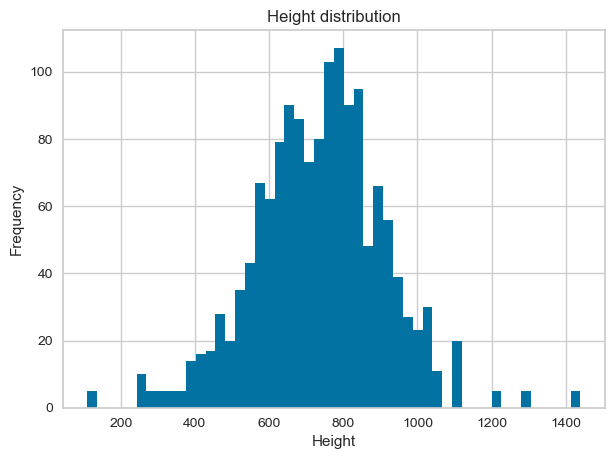

In [92]:
plot_distribution(patient_data['height'], title='Height distribution', xlabel='Height')

## Visually summarise the entire dataset in whichever way you think is most appropriate.

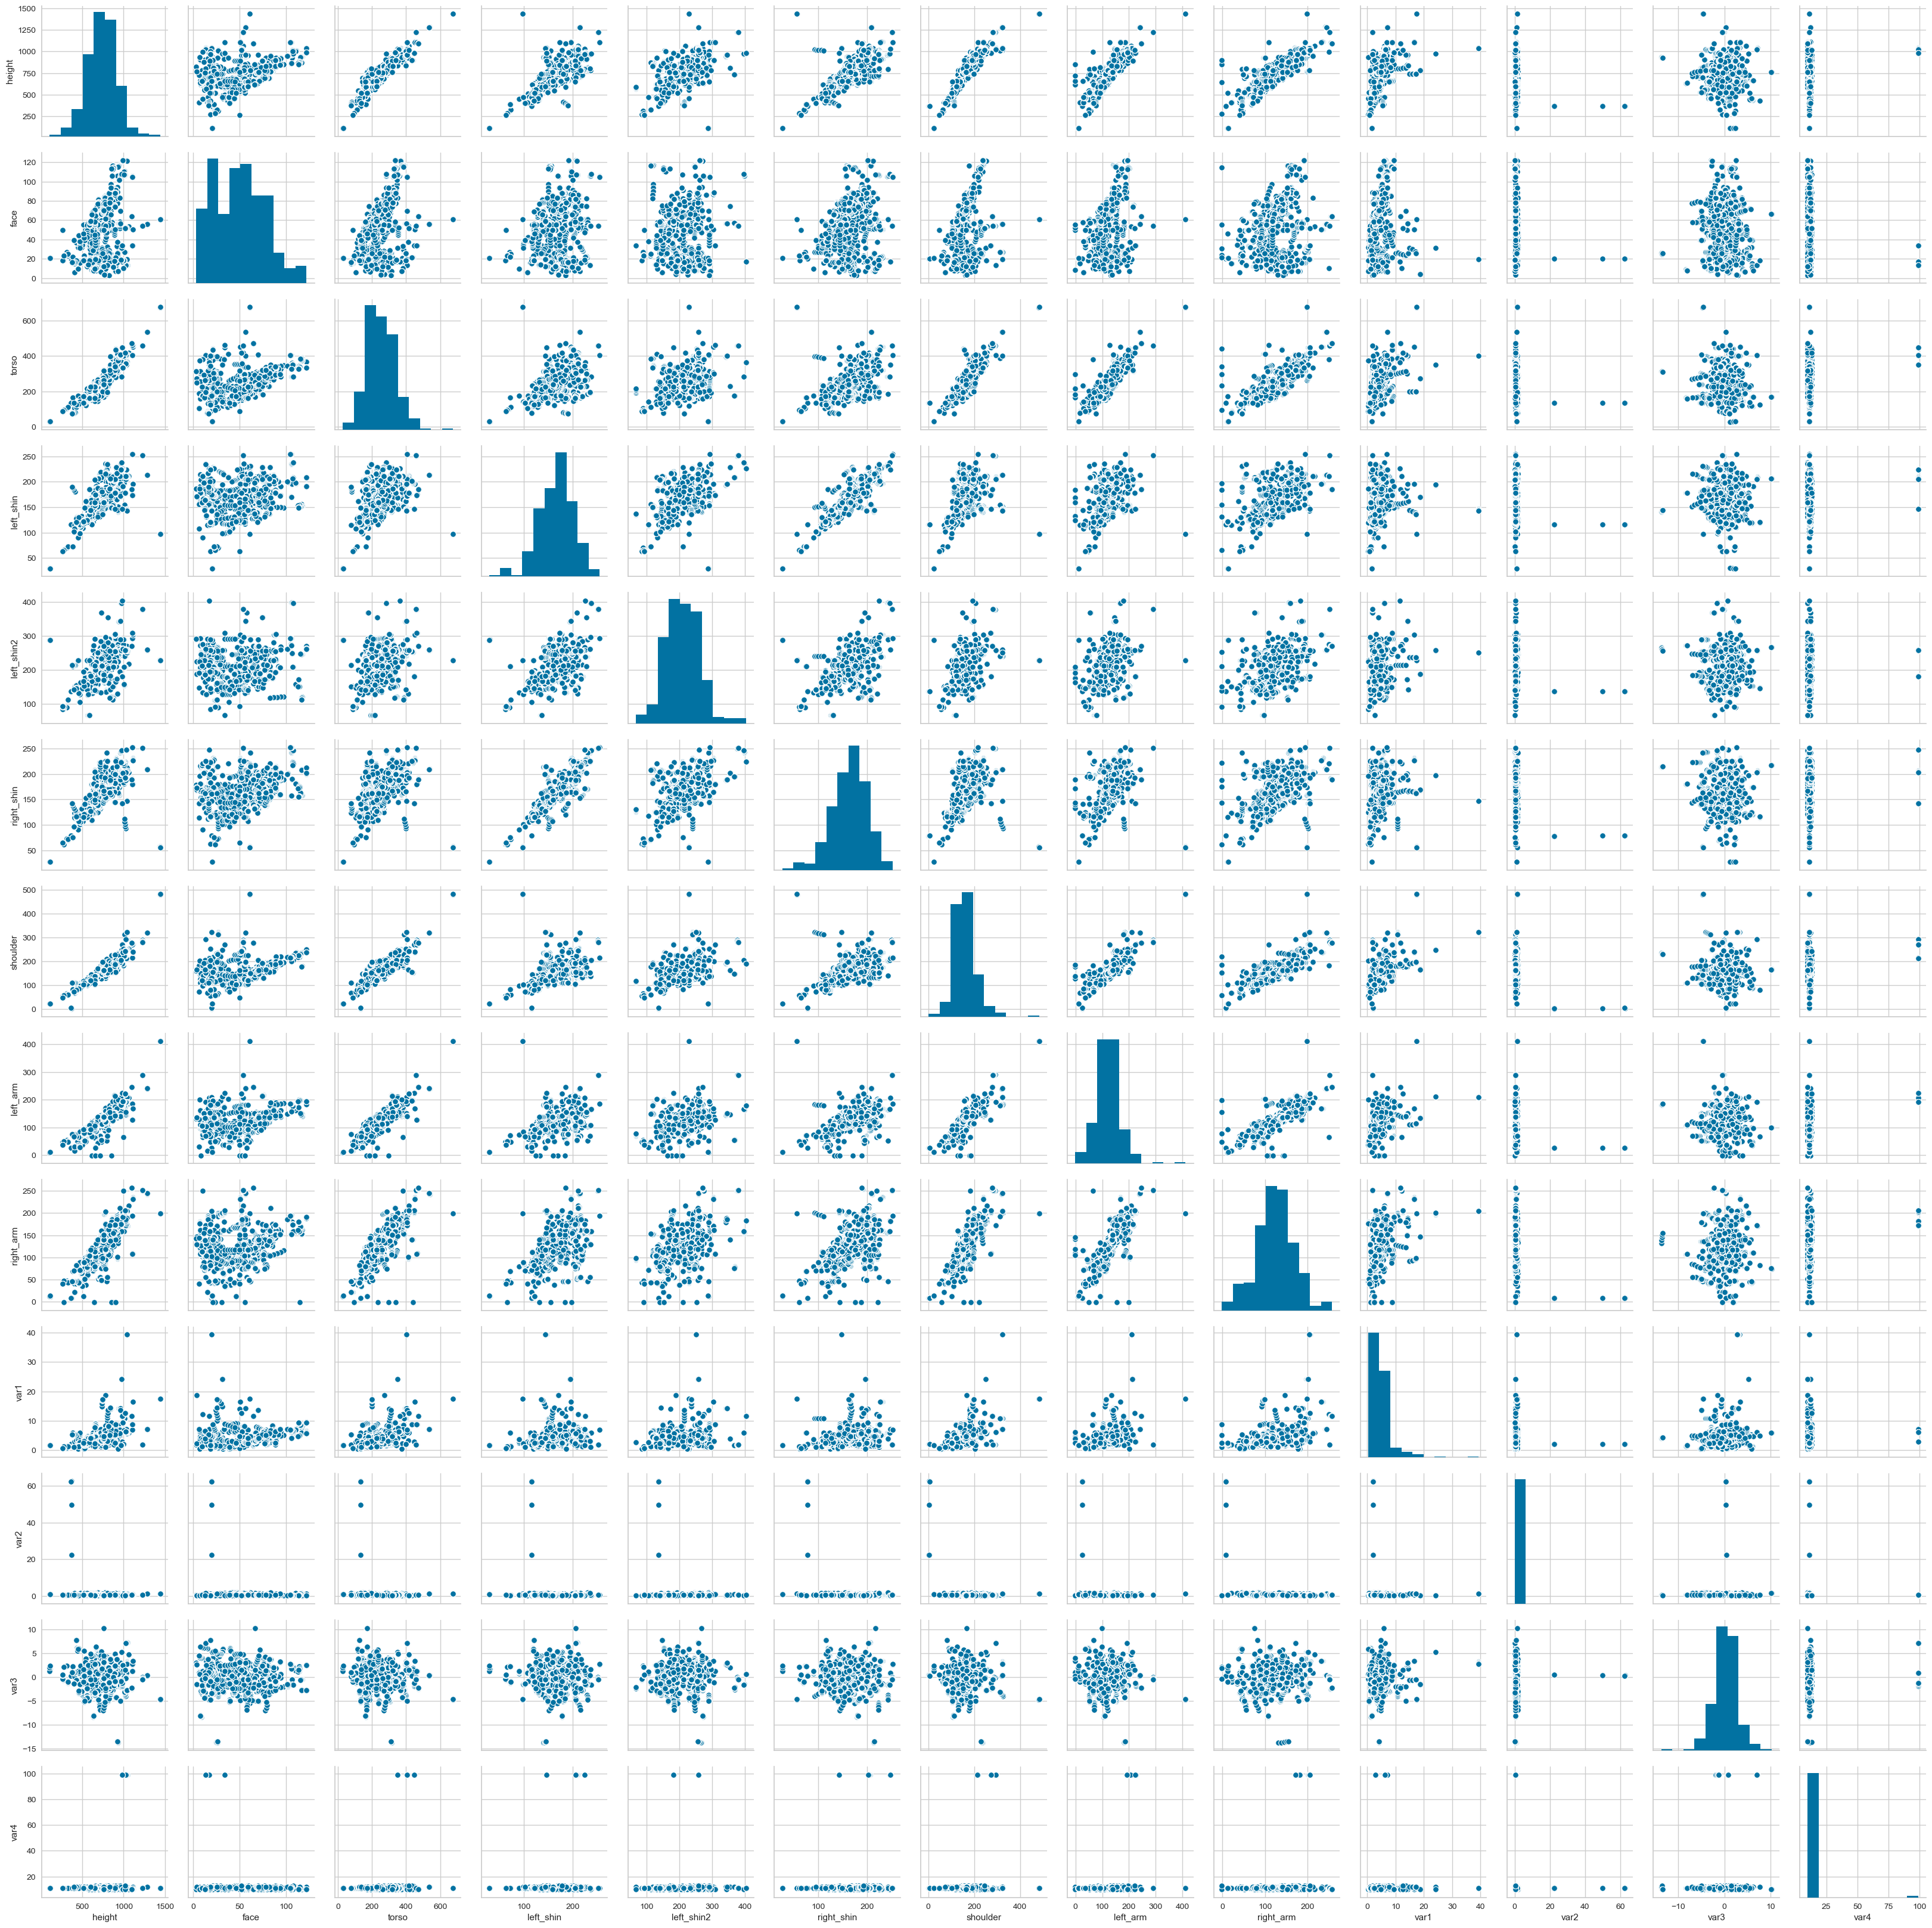

In [93]:
sns.pairplot(patient_data);

<Figure size 3000x3000 with 0 Axes>

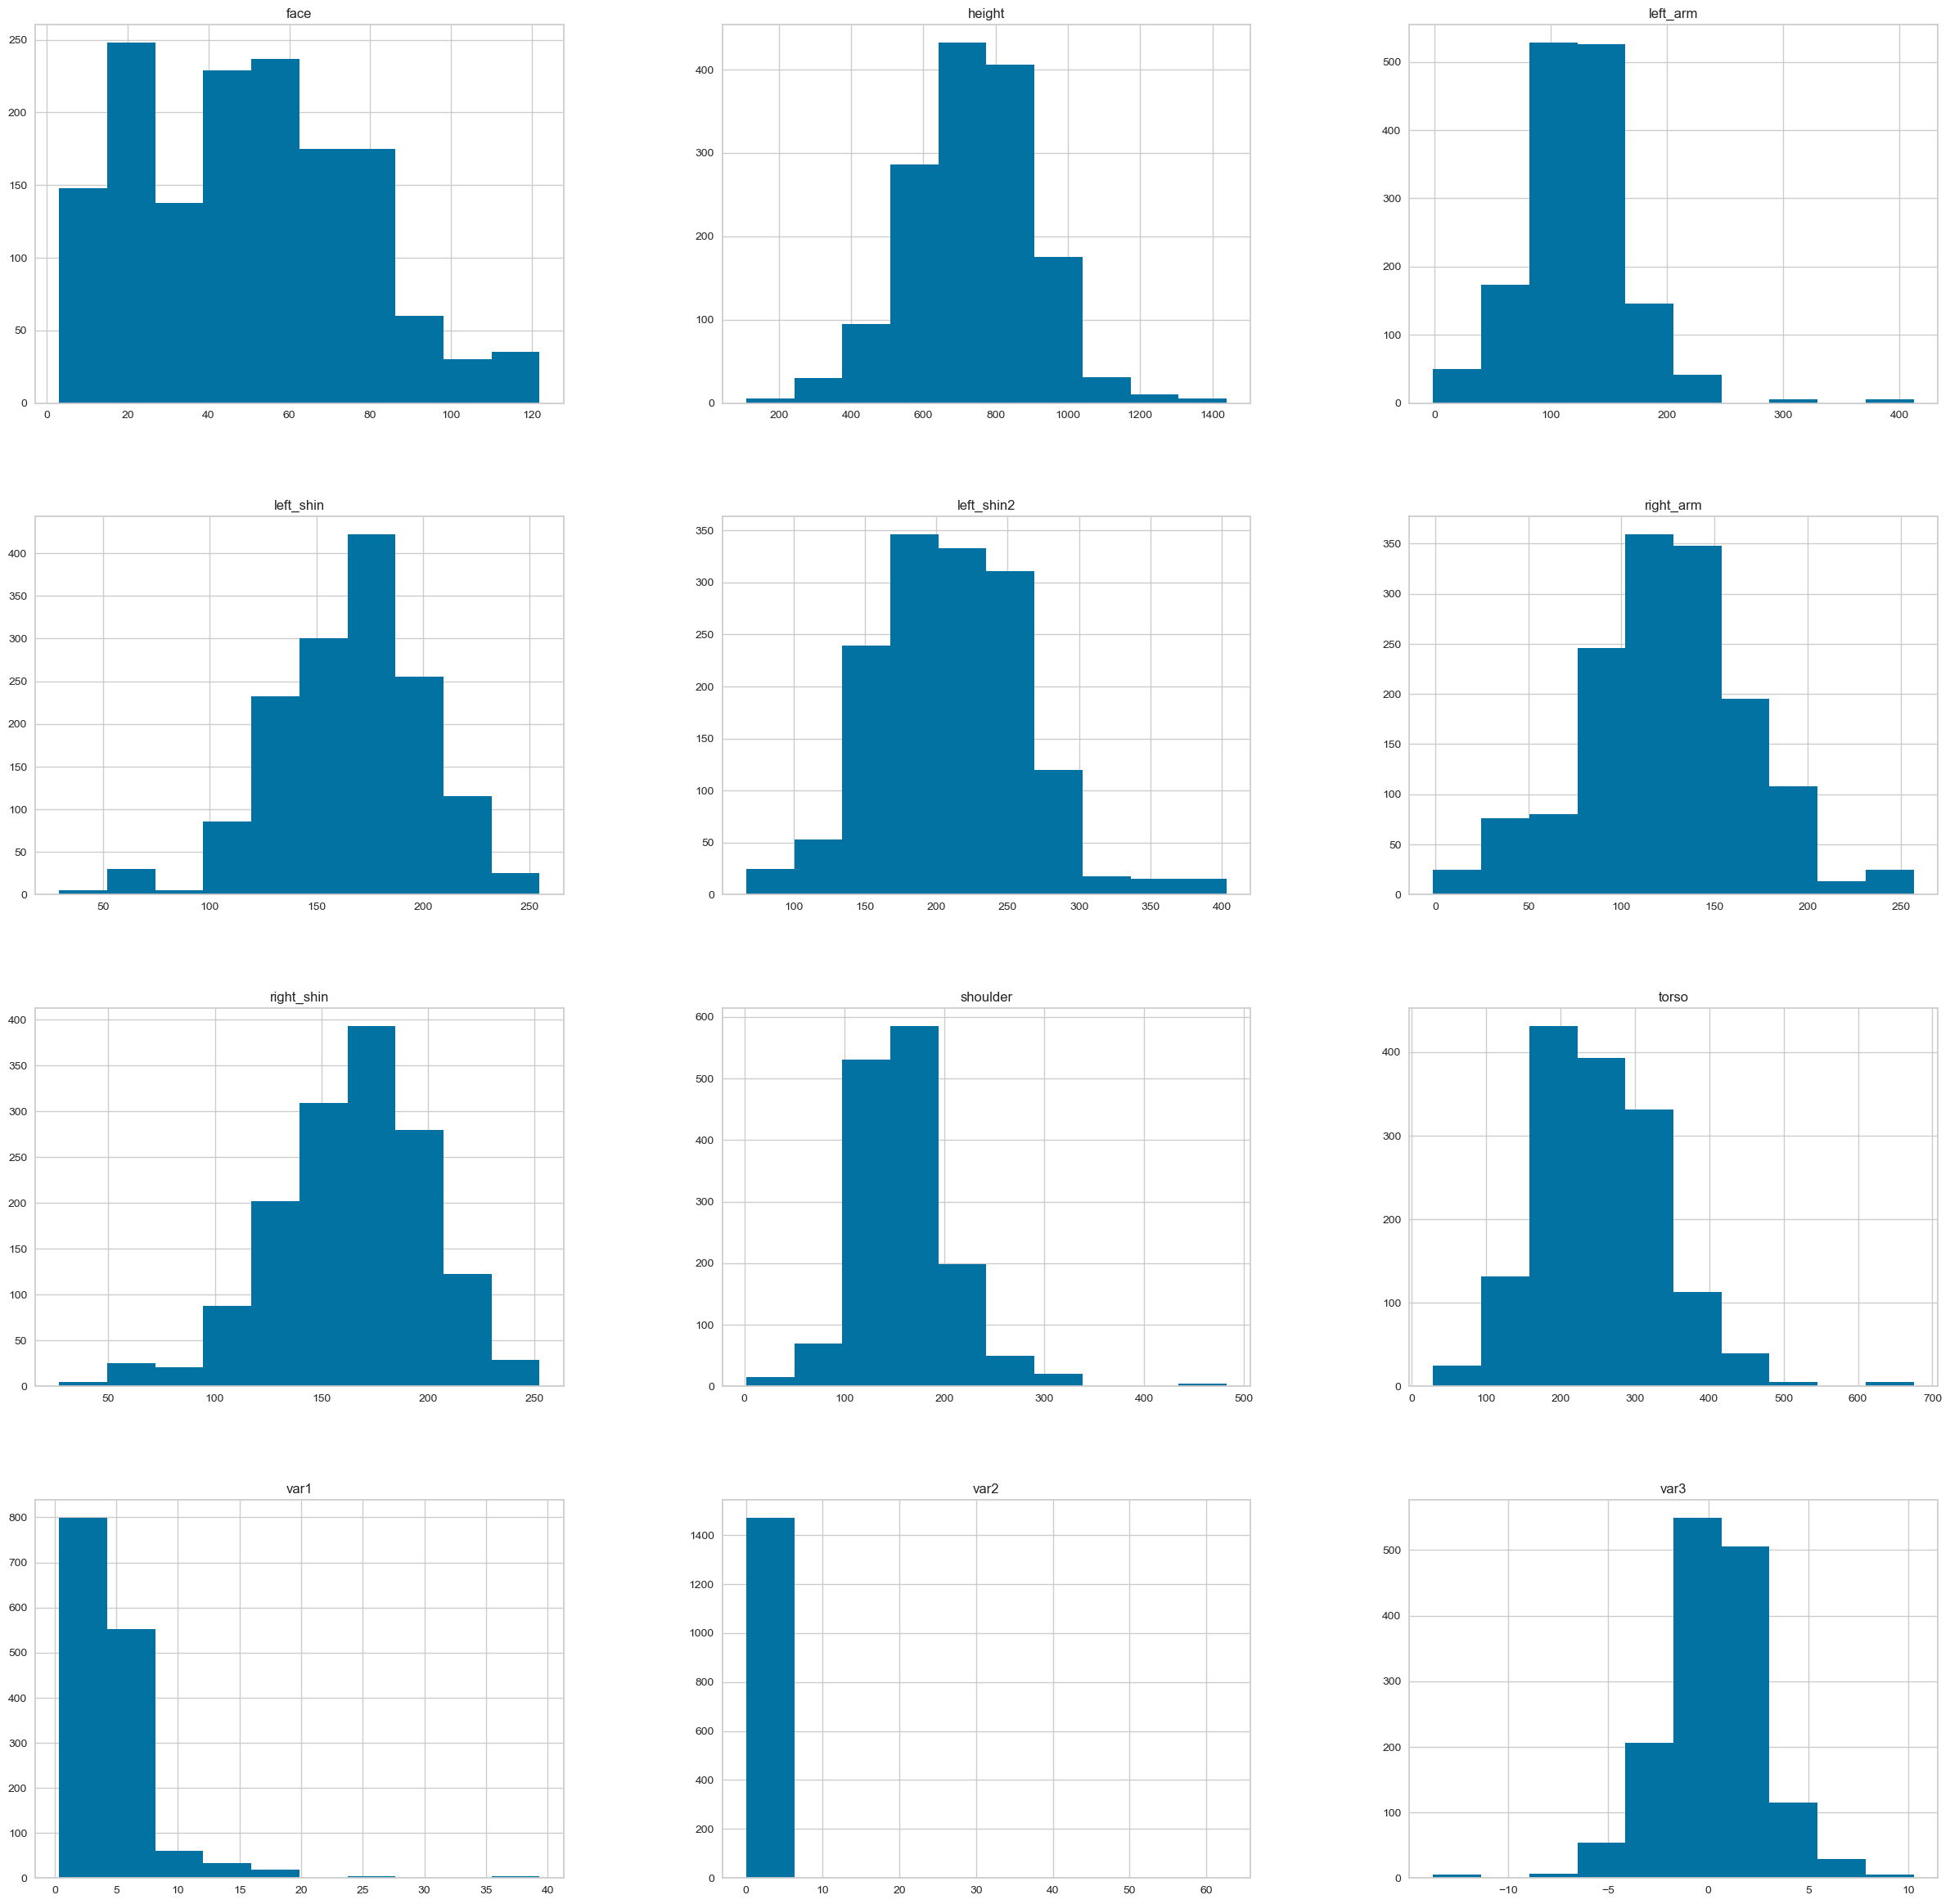

In [94]:
# Plotting the histograms of the features
plt.figure(figsize=(30,30))
patient_data.iloc[:,:12].hist(figsize=(30,30));

- The data seems to be mostly normally distributed with linearity between the features and the response variable.

## Using this dataset, provide an estimate of the average patient height. Is it significantly greater than 750?

In [143]:
np.mean(patient_data['height'])

736.4908445744045

- The estimated average patient height for this dataset is 736.5 and No, it is not significantly greater than 750.

## Characterise the distribution of the torso length (i.e. a sentence with numeric values).

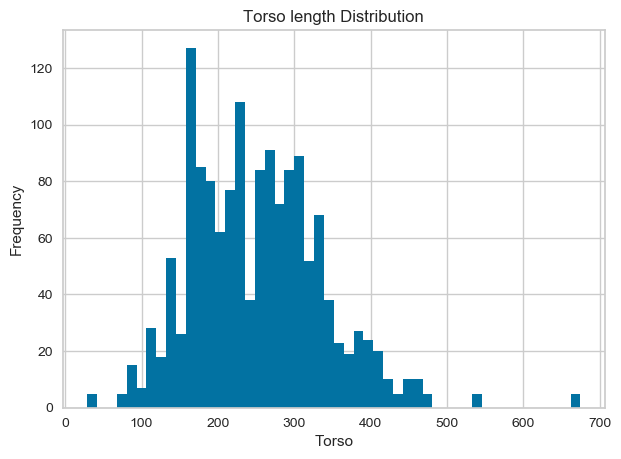

In [95]:
plot_distribution(patient_data['torso'], title='Torso length Distribution', xlabel='Torso')

In [96]:
patient_data['torso'].skew()

0.65891591802323

- Torso length is moderately skewed gamma distribution with a skewness of 0.66. It seems to have right skewed distribution with a mean of 251.35 and minimum length of 28.810246 and maximum length of 674.834122. It may require transformations to fix the distribution.

### Checking skewness

In [97]:
# Identifying the skewness accross various features

skew_features=patient_data.skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_features})
skewness

,Skew
var2,19.780681
var4,9.653347
var1,4.252654
shoulder,1.276921
left_arm,0.902430
torso,0.658916
left_shin2,0.378653
face,0.298383
right_arm,0.018478
height,-0.000220


In [98]:
# log transformations on highly skewed features
cols = ['var2', 'var1']

for col in cols:
    patient_data[col] = np.log(patient_data[col])
patient_data.skew()

height       -0.000220
face          0.298383
torso         0.658916
left_shin    -0.457066
left_shin2    0.378653
right_shin   -0.434038
shoulder      1.276921
left_arm      0.902430
right_arm     0.018478
var1         -0.280072
var2          1.429988
var3         -0.438742
var4          9.653347
dtype: float64

## Using whichever statistical test you think appropriate, examine the difference between the length of left arm and length of right arm.

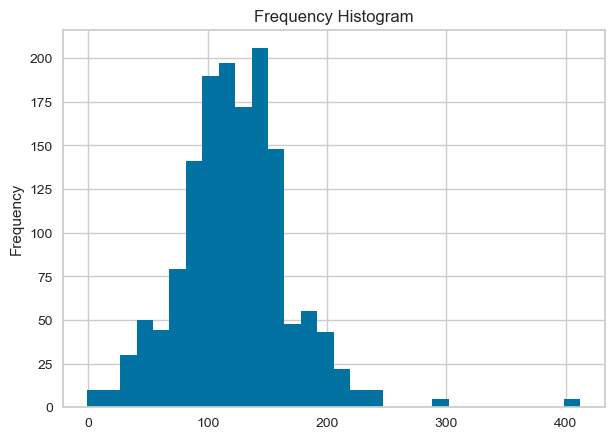

In [99]:
plot_distribution(patient_data['left_arm'], bins=30)

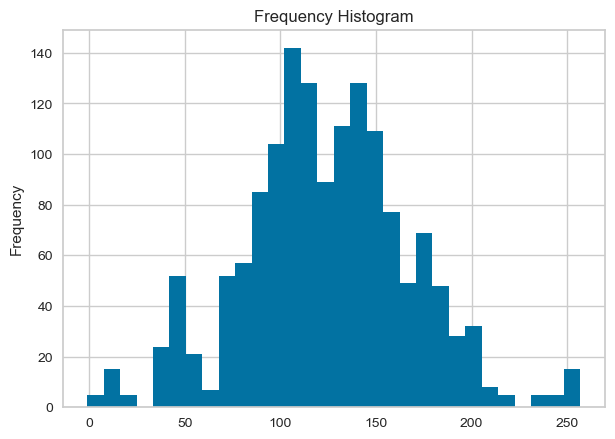

In [100]:
plot_distribution(patient_data['right_arm'],bins=30)

In [101]:
# peforming a 2 sample t-test
t, p = ttest_ind(patient_data['left_arm'], patient_data['right_arm'], equal_var=False)

In [102]:
print("ttest_ind:t={}, p={}".format(t,p))

ttest_ind:t=-0.41629016927388884, p=0.6772280568137528


- In order to identify the difference between the length of left arm and right arm we perform the t-test with the following hypothesis testing.
    - Null Hypothesis: Length of left arm and length of right arm are equal.
    - Alternate Hypothesis: Length of left arm and length or right arm are not equal.
- The results of our t-test suggest a p-value of 0.677 which is greater than our significance value of 0.05. Hence, we cannot reject the null hypothesis and say that there are no difference between the length of left arm and right arm.

## Compare the “left_shin” and “left_shin2” columns – what conclusion can you draw?

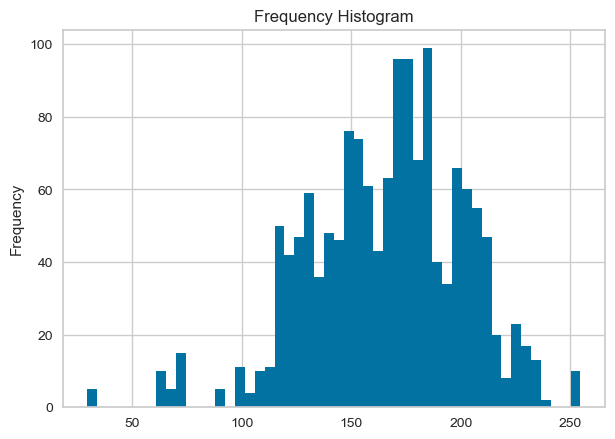

In [103]:
plot_distribution(patient_data['left_shin'], bins=50)

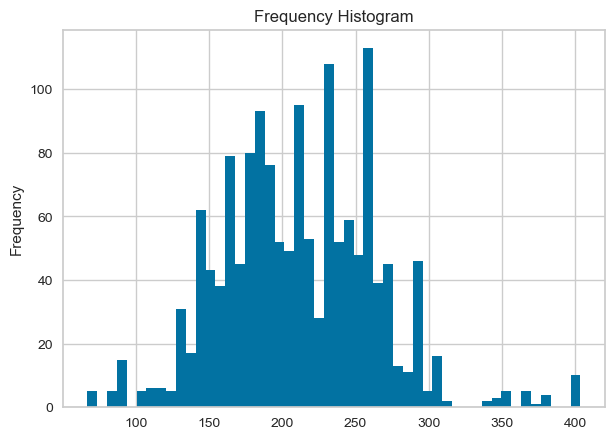

In [104]:
plot_distribution(patient_data['left_shin2'], bins=50)

In [105]:
# Performing a 2 sample t-test
t, p = ttest_ind(patient_data['left_shin'], patient_data['left_shin2'], equal_var=False)

In [106]:
print("ttest_ind:t={}, p={}".format(t,p))

ttest_ind:t=-27.287132279835497, p=2.9208083367649206e-144


- We compare the left_shin1 and left_shin2 lengths to see if they are different using a t-test. The hypothesis for this test are:
    - Null Hypothesis: There are no differences between the Length of left_shin1 and length of left_shin2.
    - Alternate Hypothesis: There are differences between the Length of left_shin1 and length of left_shin2.
- The results of our t-test suggest a p-value of 2.92e-144 which is very less than our significance value of 0.05. Hence, we reject the null hypothesis and say that there are differences between the length of left shin1 and left shin2.

## Train a simple model to predict height using all other variables. Visualise the performance of this model.

### Scaling of the data

In [128]:
# Splitting into target y and feature matrix X
X = patient_data.iloc[:,1:]
y = patient_data.iloc[:,0]

In [129]:
# Splitting the dataset to train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=1)

print("Shape of X train set:",X_train.shape)
print("Shape of X test set:",X_test.shape)
print("Shape of y train set:",y_train.shape)
print("Shape of y test set:",y_test.shape)

Shape of X train set: (1180, 12)
Shape of X test set: (295, 12)
Shape of y train set: (1180,)
Shape of y test set: (295,)


In [130]:
# Creating a Standard Scaler
ss = StandardScaler()

# Transforming the data using the scaler
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

- Creating the standard scaler and fit transforming on train and using this scaler to transform the test data.

### Model implementation

In [131]:
# Creation of linear model
lr_model = linear_model.LinearRegression()

In [132]:
# Fitting the model to the scaled train data and response
lr_model = lr_model.fit(X_train_scaled, y_train)

In [133]:
# Predicting the height by using the model
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

In [134]:
# Checking for the Error and R2 of the model on train data
print('MAE Train:', metrics.mean_absolute_error(y_train, y_train_pred))
print('R2 score Train:',metrics.r2_score(y_train, y_train_pred))
print('RMSE Train:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

MAE Train: 11.429423999667566
R2 score Train: 0.9907806522651836
RMSE Train: 16.939703746376413


In [135]:
# Calculating the metrics for our model performance
print('MAE Test:', metrics.mean_absolute_error(y_test, y_test_pred))
print('R2 score Test:',metrics.r2_score(y_test, y_test_pred))
print('RMSE Test:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

MAE Test: 11.299269759789045
R2 score Test: 0.9923275560312587
RMSE Test: 15.627369367046638


- We see that the model did not overfit on the test data and we have a good R2 as well.

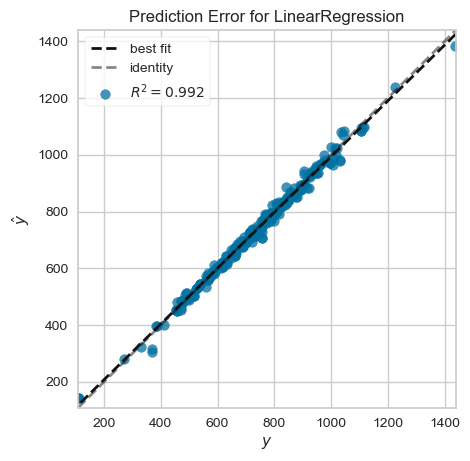

In [136]:
# Visualizing the prediction error for the linear model
visualizer = PredictionError(lr_model)
visualizer.fit(X_train_scaled, y_train)  
visualizer.score(X_test_scaled, y_test)  
visualizer.poof()

- The above plot for predictione error suggests that there isn't a huge difference between the predicted and actual values.

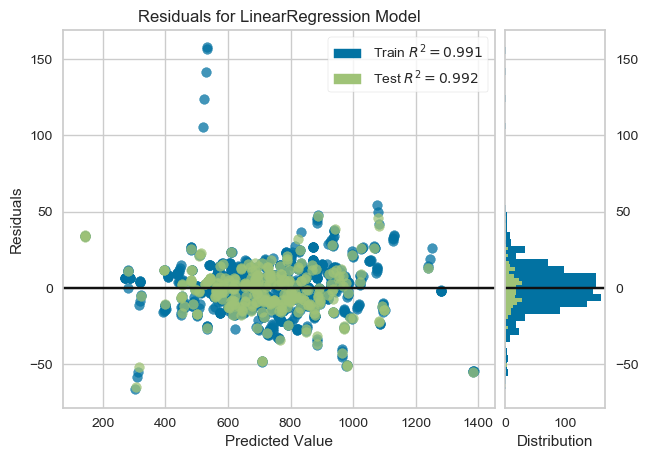

In [137]:
# Plotting the residual plot for the linear model
visualizer = ResidualsPlot(lr_model)
visualizer.fit(X_train_scaled, y_train)  
visualizer.score(X_test_scaled, y_test)  
visualizer.poof()

- The residual plot shows the various predictions and their residuals distinguished for both train and test. The predictions for both train and test are quite similar and consistent. It performs well for both.

## Train a more complex model to predict height. Compare the performance of these two models.

In [138]:
# Plotting a complex tree based algorithm random forest onto the dataset
rf = RandomForestRegressor()

In [139]:
# Fitting the model to our train data
rf_model = rf.fit(X_train, y_train)

In [140]:
# Predicting the train and test
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [141]:
# Calculating the metrics for the model on train data
print('MAE Train:', metrics.mean_absolute_error(y_train, y_train_pred))
print('R2 score Train:',metrics.r2_score(y_train, y_train_pred))
print('RMSE Train:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

MAE Train: 1.4204910707554725
R2 score Train: 0.9997581369889733
RMSE Train: 2.7437241154937473


In [142]:
# Calculating the metrics for our model performance on test data
print('MAE Test:', metrics.mean_absolute_error(y_test, y_test_pred))
print('R2 score Test:',metrics.r2_score(y_test, y_test_pred))
print('RMSE Test:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

MAE Test: 3.3074796523216974
R2 score Test: 0.9988597150905391
RMSE Test: 6.02456511801848


- We notice that the model definetely overfitted on our dataset.
- It recording low error for train and more on test which suggests that it performed not as well on test as on train.

In [944]:
# creating a parameter grid for cross validation and hyper parameter tuning

param_grid = {
    'max_depth': [10,20,40],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [6, 7, 8, 10],
    'n_estimators': [300,400,500],
    'max_features': ['sqrt']
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

# # finding the best parameter from our cross validation
grid_search.fit(X_train, y_train)
print("Best parameters are:",grid_search.best_params_)

# # we are creating model out of the best grid generated by the cross validation
best_grid = grid_search.best_estimator_

# # predicting the values using X_test data set
y_pred_test = best_grid.predict(X_test)

# # predicting with the train set
y_pred_train = best_grid.predict(X_train)

# # Calculating the metrics for our model performance
print('MAE Train:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE Train:', metrics.mean_squared_error(y_train, y_pred_train))
print('R2 score Train:',metrics.r2_score(y_train, y_pred_train))
print('RMSE Train:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

# # Calculating the metrics for our model performance
print('MAE Test:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE Test:', metrics.mean_squared_error(y_test, y_pred_test))
print('R2 score Test:',metrics.r2_score(y_test, y_pred_test))
print('RMSE Test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters are: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 400}
MAE Train: 2.793871218528579
MSE Train: 36.18269351682907
R2 score Train: 0.9988375093516559
RMSE Train: 6.015205193243957
MAE Test: 6.013252837891547
MSE Test: 144.60865397430135
R2 score Test: 0.9954568585913958
RMSE Test: 12.025333840451223


#### Conclusion:

- Even afer multiple attempts on the hyper parameter tuning we still see that there is no significant improvement.
- Hence, we concluded that the simple model performed well in this case and dataset. Also, it is to be noted that dataset is pretty small and by getting more data our model performance for random forest may improve.